In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib

In [83]:
df = pd.read_csv("train.csv")

In [84]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [85]:
df.duplicated().sum()

np.int64(0)

In [86]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [87]:
df['Cabin'] = df['Cabin'].str.replace('C', '', regex=False)

In [88]:
df['Cabin'] = df['Cabin'].str.replace('NaN', '0', regex=False)

In [89]:
del df['Cabin'] 

In [90]:
del df['Name']

In [91]:
del df['Ticket']

In [92]:
df['Age'] = df['Age'].fillna(df['Age'].median())

In [93]:
df['Age'] = df['Age'].astype(int)

In [94]:
del df['PassengerId']

In [95]:
encoder = LabelEncoder()

In [96]:
df['Embarked'] = encoder.fit_transform(df['Embarked'])

In [97]:
df['Sex'] = encoder.fit_transform(df['Sex'])

In [98]:
def wrangle(c):
    df = pd.read_csv(c)
    
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()

    
    for col in ["Sex", "Embarked"]:
        if col in df.columns:
            df[col] = encoder.fit_transform(df[col])

    
    df = df.drop(columns=["Cabin", "Name", "Ticket", "PassengerId" ], errors="ignore")

    return df

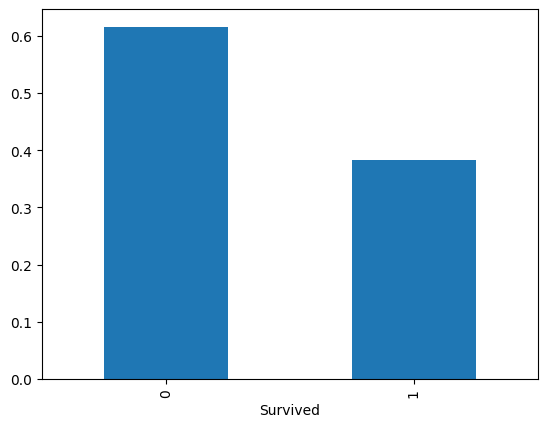

In [99]:
df['Survived'].value_counts(normalize=True).plot(kind='bar')
plt.show()

In [100]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [102]:
over_sampler = RandomOverSampler()
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

In [103]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

In [104]:
params = {
    'n_estimators': range(25, 100, 25),
    'max_depth': range(10, 50, 10)
}

In [105]:
clf = RandomForestClassifier(random_state=30)

In [106]:
cross_val = cross_val_score(clf, X_train_over, y_train_over, cv=cv, n_jobs=1)
print(cross_val)

[0.88135593 0.9039548  0.86931818 0.85227273 0.83522727]


In [107]:
model = GridSearchCV(
    clf,
    param_grid = params,
    cv = cv,
    n_jobs = 1,
    verbose = 1
    )

In [113]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=RandomForestClassifier(random_state=30), n_jobs=1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [114]:
cv_results = pd.DataFrame(model.cv_results_)
print(cv_results.head(1))

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.09423      0.010627         0.009642        0.002608   

   param_max_depth  param_n_estimators                                 params  \
0               10                  25  {'max_depth': 10, 'n_estimators': 25}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.881356           0.870056           0.835227           0.829545   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.823864          0.84801        0.023175               12  


In [115]:
best_model = model.best_estimator_
print(best_model)

RandomForestClassifier(max_depth=20, n_estimators=50, random_state=30)


In [116]:
model.score(X_train, y_train)

0.9831460674157303

In [112]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       108
           1       0.72      0.69      0.71        71

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



In [89]:
df1 = pd.read_csv("test.csv")

In [79]:
df1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


In [101]:
df1 = wrangle("test.csv")

In [74]:
print(type(model.best_estimator_))  
joblib.dump(model.best_estimator_, 'my_model.pkl')

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


['my_model.pkl']

In [87]:
loaded_model = joblib.load('my_model.pkl')
print(type(loaded_model))  

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [80]:
prediction = loaded_model.predict(df1)

In [102]:
try:
    probabilities = loaded_model.predict_proba(df1)
    print(probabilities)

    df1[['prob_class0', 'prob_class1']] = probabilities  
    #print(new_data)
except AttributeError:
    pass 

[[0.88       0.12      ]
 [0.84       0.16      ]
 [0.76       0.24      ]
 [0.24       0.76      ]
 [0.52       0.48      ]
 [0.96       0.04      ]
 [0.76       0.24      ]
 [0.84       0.16      ]
 [0.2        0.8       ]
 [0.96       0.04      ]
 [1.         0.        ]
 [0.76       0.24      ]
 [0.04       0.96      ]
 [0.96       0.04      ]
 [0.04       0.96      ]
 [0.04       0.96      ]
 [0.86666667 0.13333333]
 [0.44       0.56      ]
 [0.72       0.28      ]
 [0.44       0.56      ]
 [0.2        0.8       ]
 [0.56       0.44      ]
 [0.         1.        ]
 [0.52       0.48      ]
 [0.04       0.96      ]
 [1.         0.        ]
 [0.         1.        ]
 [0.8        0.2       ]
 [0.48       0.52      ]
 [0.88       0.12      ]
 [1.         0.        ]
 [0.84       0.16      ]
 [0.04       0.96      ]
 [0.48       0.52      ]
 [0.4        0.6       ]
 [0.16       0.84      ]
 [0.68       0.32      ]
 [0.72       0.28      ]
 [1.         0.        ]
 [0.224      0.776     ]


In [84]:
print(type(model.best_params_))  
joblib.dump(model.best_params_, 'my_model1.pkl')

<class 'dict'>


['my_model1.pkl']

In [ ]:
loaded_model = joblib.load('my_model.pkl')
print(type(loaded_model)) 

In [85]:
df1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,prob_class0,prob_class1
0,3,1,34.5,0,0,7.8292,1,0.88,0.12
1,3,0,47.0,1,0,7.0000,2,0.84,0.16
2,2,1,62.0,0,0,9.6875,1,0.76,0.24
3,3,1,27.0,0,0,8.6625,2,0.24,0.76
4,3,0,22.0,1,1,12.2875,2,0.52,0.48
